## HOUSE PRICE PREDICTION USING TEXT AND IMAGES 



##Import Libraries


In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image
from google.colab import drive

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D,\
                                    concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split

from collections.abc import Sequence
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.applications.vgg16 import VGG16

## Load helper functions

In [ ]:
class AI_Helper:
    def __init__(self):
        pass
    
    # Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
    def encode_text_dummy(self, df, name):
        dummies = pd.get_dummies(df[name])
        for x in dummies.columns:
            dummy_name = "{}-{}".format(name, x)
            df[dummy_name] = dummies[x]
        df.drop(name, axis=1, inplace=True)



    # Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
    def encode_text_index(self, df, name):
        le = preprocessing.LabelEncoder()
        df[name] = le.fit_transform(df[name])
        return le.classes_


    # Encode a numeric column as zscores
    def encode_numeric_zscore(self, df, name, mean=None, sd=None):
        if mean is None:
            mean = df[name].mean()

        if sd is None:
            sd = df[name].std()

        df[name] = (df[name] - mean) / sd


    # Convert all missing values in the specified column to the median
    def missing_median(self, df, name):
        med = df[name].median()
        df[name] = df[name].fillna(med)


    # Convert all missing values in the specified column to the default
    def missing_default(self, df, name, default_value):
        df[name] = df[name].fillna(default_value)


    # Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
    def to_xy(self, df, target):
        result = []
        for x in df.columns:
            if x != target:
                result.append(x)
        # find out the type of the target column. 
        target_type = df[target].dtypes
        target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
        # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
        if target_type in (np.int64, np.int32):
            # Classification
            print('Classification')
            dummies = pd.get_dummies(df[target])
            return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
        else:
            # Regression
            print('Regression')
            return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    # Nicely formatted time string
    def hms_string(self, sec_elapsed):
        h = int(sec_elapsed / (60 * 60))
        m = int((sec_elapsed % (60 * 60)) / 60)
        s = sec_elapsed % 60
        return "{}:{:>02}:{:>05.2f}".format(h, m, s)


    # Regression chart.
    def chart_regression(self, pred,y,sort=True):
        t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
        if sort:
            t.sort_values(by=['y'],inplace=True)
        a = plt.plot(t['y'].tolist(),label='expected')
        b = plt.plot(t['pred'].tolist(),label='prediction')
        plt.ylabel('output')
        plt.legend()
        plt.show()

    # Remove all rows where the specified column is +/- sd standard deviations
    def remove_outliers(self, df, name, sd):
        drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
        df.drop(drop_rows, axis=0, inplace=True)


    # Encode a column to a range between normalized_low and normalized_high.
    def encode_numeric_range(self, df, name, normalized_low=-1, normalized_high=1,
                             data_low=None, data_high=None):
        if data_low is None:
            data_low = min(df[name])
            data_high = max(df[name])

        df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                   * (normalized_high - normalized_low) + normalized_low

    def list_diff(self, list1, list2):
        return (list(list(set(list1)-set(list2)) + list(set(list2)-set(list1)))) 


    # Plot a confusion matrix.
    # cm is the confusion matrix, names are the names of the classes.
    def plot_confusion_matrix(self, cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(names))
        plt.xticks(tick_marks, names, rotation=45)
        plt.yticks(tick_marks, names)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()


    # Plot an ROC. pred - the predictions, y - the expected output.
    def plot_roc(self, pred,y):
        fpr, tpr, thresholds = roc_curve(y, pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()
        
    def to_sequences_nn(self, data, y_data, SEQUENCE_SIZE):
        x = []
        y = []

        for i in range(len(data)-SEQUENCE_SIZE-1):
            #print(i)
            window = data[i:(i+SEQUENCE_SIZE)]
            after_window = y_data[i+SEQUENCE_SIZE]
            #window = [[x] for x in window]
            #print("{} - {}".format(window,after_window))
            x.append(window)
            y.append(after_window)

        return np.array(x),np.array(y)
    
    def to_sequences_rnn(self, data, seq_size):
        x = []
        y = []

        for i in range(len(data)-seq_size-1):
            #print(i)
            window = data[i:(i+seq_size)]
            after_window = data[i+seq_size]
            window = [[x] for x in window]
            #print("{} - {}".format(window,after_window))
            x.append(window)
            y.append(after_window)

        return np.array(x),np.array(y)

ai_helper = AI_Helper()

## Load dataset from google drive

In [ ]:
drive.mount('/content/drive')
# dataset_path = "./data/"
dataset_path = "/content/drive/My Drive/Colab Notebooks/"
filename_read = os.path.join(dataset_path, "Houses_Dataset/HousesInfo.txt")

Mounted at /content/drive


In [ ]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]

# Check for invalid values


In [ ]:
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols, na_values=[0,'NA','?',None,'None','0'])

In [ ]:
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [ ]:
df.shape

(535, 5)

In [ ]:
df.isna().sum()

## Data Preprocessing
- Removing outliers
- Split data into train and test
- Encode categorical features
- Normalize numerical features

#### Removing Outliers - filter out the house records whose price is less than 100,000 and more than 900,000

In [ ]:
df_outliers = df.index[df['price']<100*1000].tolist()
df_outliers += df.index[df['price']>900*1000].tolist()
df_outliers.sort()

df = df[df['price'].between(100*1000, 900*1000)]
print("shape of df after removing outliers: {}".format(df.shape))
df

shape of df after removing outliers: (406, 5)


,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200
...,...,...,...,...,...
530,5,2.0,2066,94531,399900
531,4,3.5,9536,94531,460000
532,3,2.0,2014,94531,407000
533,4,3.0,2312,94531,419000


In [ ]:
#df_outliers

# Additional feature : filtering out the data set with the zipcode feature. 
## The data is filtered with zip codes having equal to or more than 25 houses
### This code was commented for the base model


In [ ]:
df_outliers += df.groupby('zipcode')\
    .filter(lambda x: len(x) < 25).index.tolist()
df = df.groupby('zipcode').filter(lambda x: len(x) >= 25)
df['zipcode'].value_counts(dropna=False)

93510    59
92276    54
92880    49
93446    49
94501    31
Name: zipcode, dtype: int64

#### Encode categorical features

In [ ]:
columns = ['zipcode', 'Bedrooms', 'Bathrooms']
for column in columns:
    ai_helper.encode_text_dummy(df, column)
columns = []
for column in columns:
    ai_helper.encode_text_index(df, column)
df

,area,price,zipcode-92276,zipcode-92880,zipcode-93446,zipcode-93510,zipcode-94501,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
30,2520,789000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32,1802,365000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
39,2146,455000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
98,3115,629000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
106,1826,529000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,1500,319000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
500,2330,599900,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
501,1339,344900,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
502,1472,309995,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Normalize numerical features

In [ ]:
columns = []
for column in columns:
    ai_helper.encode_numeric_zscore(df, column)
columns = ['area']
for column in columns:
    ai_helper.encode_numeric_range(df, column, normalized_low=0)
df

,area,price,zipcode-92276,zipcode-92880,zipcode-93446,zipcode-93510,zipcode-94501,Bedrooms-1,Bedrooms-2,Bedrooms-3,Bedrooms-4,Bedrooms-5,Bedrooms-6,Bedrooms-8,Bedrooms-10,Bathrooms-1.0,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
30,0.449358,789000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
32,0.271986,365000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
39,0.356966,455000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
98,0.596344,629000,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
106,0.277915,529000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,0.197381,319000,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
500,0.402421,599900,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
501,0.157609,344900,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
502,0.190464,309995,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Handling the image dataset

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob(dataset_path + "Houses_Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [ ]:
print("Length of new_images: {}".format(len(new_images)))
new_images[:5]

Length of new_images: 535


['/content/drive/My Drive/Colab Notebooks/Houses_Dataset/1_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses_Dataset/2_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses_Dataset/3_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses_Dataset/4_bathroom.jpg',
 '/content/drive/My Drive/Colab Notebooks/Houses_Dataset/5_bathroom.jpg']

In [ ]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [ ]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob(dataset_path + "Houses_Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [ ]:
img['bedroom_img']=bedroom_images

In [ ]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob(dataset_path + "Houses_Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [ ]:
img['frontal_img']=frontal_images

In [ ]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob(dataset_path + "Houses_Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [ ]:
img['kitchen_img']=kitchen_images

In [ ]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
1,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
2,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
3,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...
4,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...,/content/drive/My Drive/Colab Notebooks/Houses...


In [ ]:
print(img.shape)
img = img.drop(df_outliers)
print(img.shape)

(535, 4)
(242, 4)


## Concatenate four images into one image for each house

In [ ]:
images_output=[]
for row_index,row in img.iterrows():
    print("Processing image index: {}".format(row_index))
    inputImages=[]
    outputImage = np.zeros((128, 128, 3), dtype="uint8")
    image_temp1 = cv2.imread(row.bathroom_img)
    image1 = cv2.resize(image_temp1, (64 , 64))

    image_temp2 = cv2.imread(row.bedroom_img)
    image2 = cv2.resize(image_temp2, (64 , 64))

    image_temp3 = cv2.imread(row.frontal_img)
    image3 = cv2.resize(image_temp3, (64 , 64))

    image_temp4 = cv2.imread(row.kitchen_img)
    image4 = cv2.resize(image_temp4, (64 , 64))
      
    inputImages.append(image1)
    inputImages.append(image2)
    inputImages.append(image3)
    inputImages.append(image4)

    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]


    images_output.append(outputImage)      
            

Processing image index: 30
Processing image index: 32
Processing image index: 39
Processing image index: 98
Processing image index: 106
Processing image index: 173
Processing image index: 174
Processing image index: 175
Processing image index: 176
Processing image index: 177
Processing image index: 178
Processing image index: 179
Processing image index: 180
Processing image index: 181
Processing image index: 182
Processing image index: 183
Processing image index: 187
Processing image index: 188
Processing image index: 189
Processing image index: 191
Processing image index: 193
Processing image index: 194
Processing image index: 195
Processing image index: 196
Processing image index: 197
Processing image index: 198
Processing image index: 199
Processing image index: 200
Processing image index: 201
Processing image index: 204
Processing image index: 205
Processing image index: 206
Processing image index: 208
Processing image index: 210
Processing image index: 211
Processing image index: 

# Plotting the single image for each house

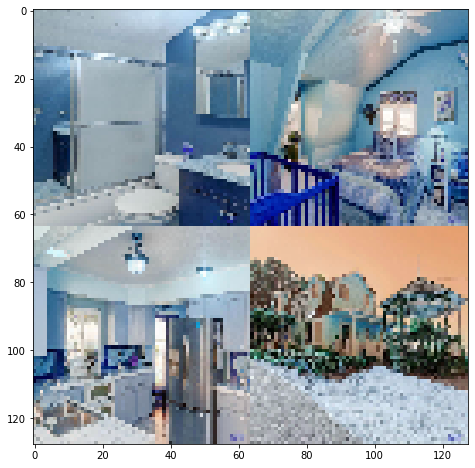

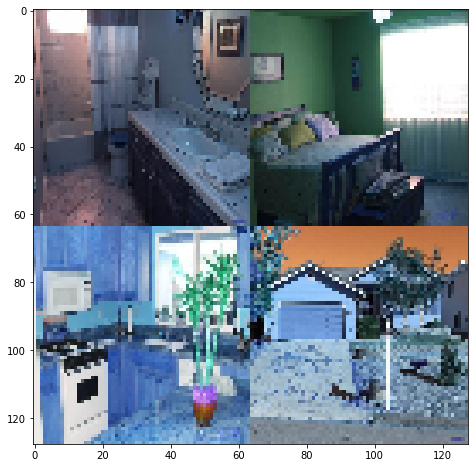

In [ ]:
from matplotlib import pyplot as plt

for i in images_output[:2]:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

## Create numpy arrays of images

In [ ]:
img_arr=np.asarray(images_output)

## Split data into train and test and normalise the image data and drop the price column for input data set 

In [ ]:
# Split numerical data and images
x_train, x_test, img_train, img_test = train_test_split(df, img_arr, 
                                                        test_size=0.30, 
                                                        random_state=22)

img_train = img_train.astype('float32')
img_test = img_test.astype('float32')
img_train /= 255.0
img_test /= 255.0


# Extract y
y_train = x_train['price'].values
y_test = x_test['price'].values

# drop price from x
x_train = x_train.drop(columns=['price']).values
x_test = x_test.drop(columns=['price']).values

print("x_train: {}\t type: {}".format(x_train.shape, type(x_train)))
print("x_test: {}\t type: {}".format(x_test.shape, type(x_test)))
print("y_train: {}\t type: {}".format(y_train.shape, type(y_train)))
print("y_test: {}\t type: {}".format(y_test.shape, type(y_test)))
print("img_train: {}\t type: {}".format(img_train.shape, type(img_train)))
print("img_test: {}\t type: {}".format(img_test.shape, type(img_test)))

x_train: (169, 25)	 type: <class 'numpy.ndarray'>
x_test: (73, 25)	 type: <class 'numpy.ndarray'>
y_train: (169,)	 type: <class 'numpy.ndarray'>
y_test: (73,)	 type: <class 'numpy.ndarray'>
img_train: (169, 128, 128, 3)	 type: <class 'numpy.ndarray'>
img_test: (73, 128, 128, 3)	 type: <class 'numpy.ndarray'>


## Create the DENSE model for textual data set and CNN model for image data set using functional API



Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 64) 3136        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 63, 63, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 60, 32)   32800       max_pooling2d[0][0]              
_______________________________________________________________________________________

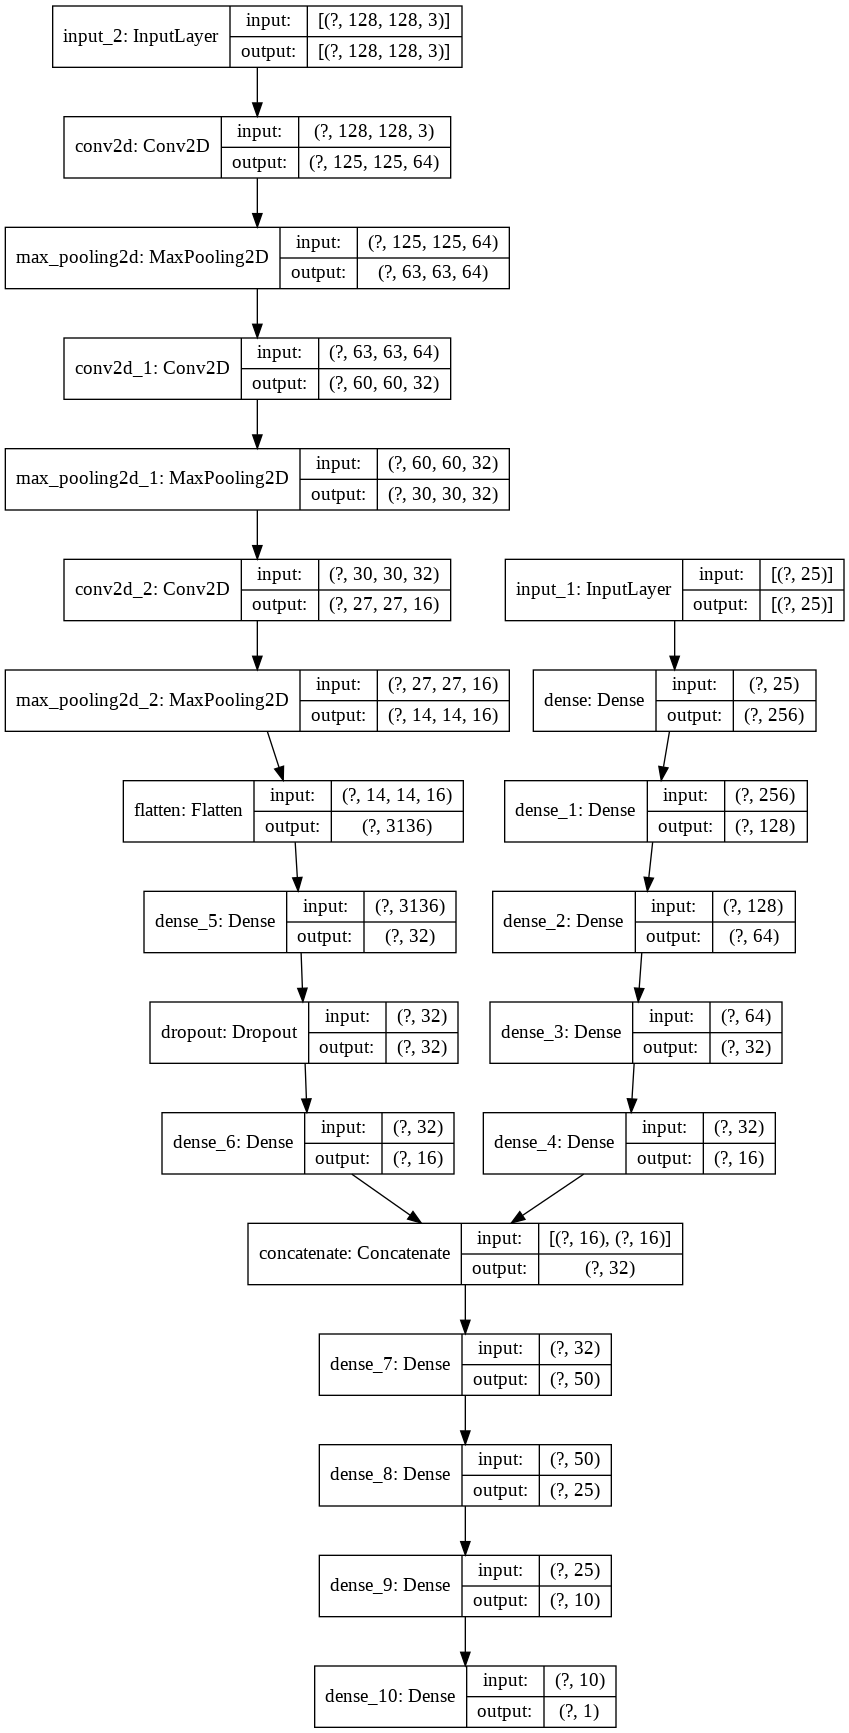

In [ ]:
checkpointer = ModelCheckpoint(filepath=dataset_path+"dnn/best_weights_project3.hdf5", 
                               verbose=0, save_best_only=True) # save best model

# input model for NN
visible_nn = Input(shape=(x_train.shape[1],))
x = Dense(256, activation='relu')(visible_nn)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
model_nn = Model(inputs=visible_nn, outputs=x)


# input model for CNN
visible_cnn = Input(shape=(img_arr.shape[1], img_arr.shape[2], img_arr.shape[3]))

conv1 = Conv2D(64, kernel_size=4, activation='relu')(visible_cnn)
pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

conv1 = Conv2D(32, kernel_size=4, activation='relu')(pool1)
pool1 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv1)

conv2 = Conv2D(16, kernel_size=4, activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), padding = 'same')(conv2)

flat1 = Flatten()(pool2)
dense = Dense(32, activation='relu')(flat1)
dropout = Dropout(0.5)(dense)

dense = Dense(16, activation='relu')(dropout)

model_cnn = Model(inputs=visible_cnn, outputs=dense)


# merge input models
merge = concatenate([model_nn.output, model_cnn.output])

# adding more layers to the model
x = Dense(50, activation='relu')(merge)
x = Dense(25, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model(inputs=[model_nn.input, model_cnn.input], outputs=x)

print(model.summary())
plot_model(model, 
#            to_file='plots/multiple_inputs.png', 
           show_shapes=True)

# Train the data set with the model in a loop with early stopping

In [ ]:
for i in range(15):
    # adam = optimizers.Adam(lr=1e-3, decay=1e-3/200)
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                            verbose=1, mode='auto')
    print('Train... TRY {}'.format(i))
    
    model.fit([x_train, img_train], y_train, 
              validation_data=([x_test, img_test], y_test),
              callbacks=[monitor, checkpointer], verbose=2, epochs=1000,
              batch_size=32)

Train... TRY 0
Epoch 1/1000
6/6 - 1s - loss: 257611153408.0000 - val_loss: 271728787456.0000
Epoch 2/1000
6/6 - 0s - loss: 257611120640.0000 - val_loss: 271728672768.0000
Epoch 3/1000
6/6 - 0s - loss: 257610973184.0000 - val_loss: 271728328704.0000
Epoch 4/1000
6/6 - 0s - loss: 257610334208.0000 - val_loss: 271726346240.0000
Epoch 5/1000
6/6 - 0s - loss: 257605189632.0000 - val_loss: 271706439680.0000
Epoch 6/1000
6/6 - 0s - loss: 257555726336.0000 - val_loss: 271535505408.0000
Epoch 7/1000
6/6 - 0s - loss: 257161199616.0000 - val_loss: 270532313088.0000
Epoch 8/1000
6/6 - 0s - loss: 255200509952.0000 - val_loss: 265343844352.0000
Epoch 9/1000
6/6 - 0s - loss: 246096117760.0000 - val_loss: 244848787456.0000
Epoch 10/1000
6/6 - 0s - loss: 212413284352.0000 - val_loss: 182089940992.0000
Epoch 11/1000
6/6 - 0s - loss: 124240633856.0000 - val_loss: 62167990272.0000
Epoch 12/1000
6/6 - 0s - loss: 85261819904.0000 - val_loss: 40947359744.0000
Epoch 13/1000
6/6 - 0s - loss: 90219855872.0000 -

#Predict the test set with the model created and check the RMSE score

In [ ]:
# model.load_weights(dataset_path+'dnn/best_weights_project3.hdf5') # load weights from best model
pred = model.predict([x_test, img_test])

score = np.sqrt(metrics.mean_squared_error(y_test, pred)) 

print("Score (RMSE)\t: {}".format(score))
print("R2 score\t:", metrics.r2_score(y_test, pred))
print("MSE\t\t:", metrics.mean_squared_error(y_test, pred))

Score (RMSE)	: 110854.25399679583
R2 score	: 0.7220930342779719
MSE		: 12288665629.186125


#Plot the regression lift chart for the prediction

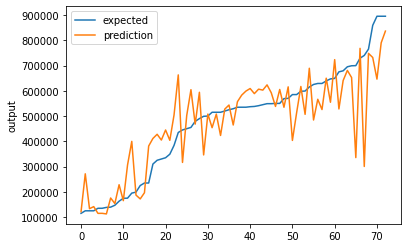

In [ ]:
ai_helper.chart_regression(pred.flatten(), y_test)

# Additional Feature - Transfer learning for the dataset


### Build NN model for text input and VGG16 model for image input


58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[1][0]               
______________________

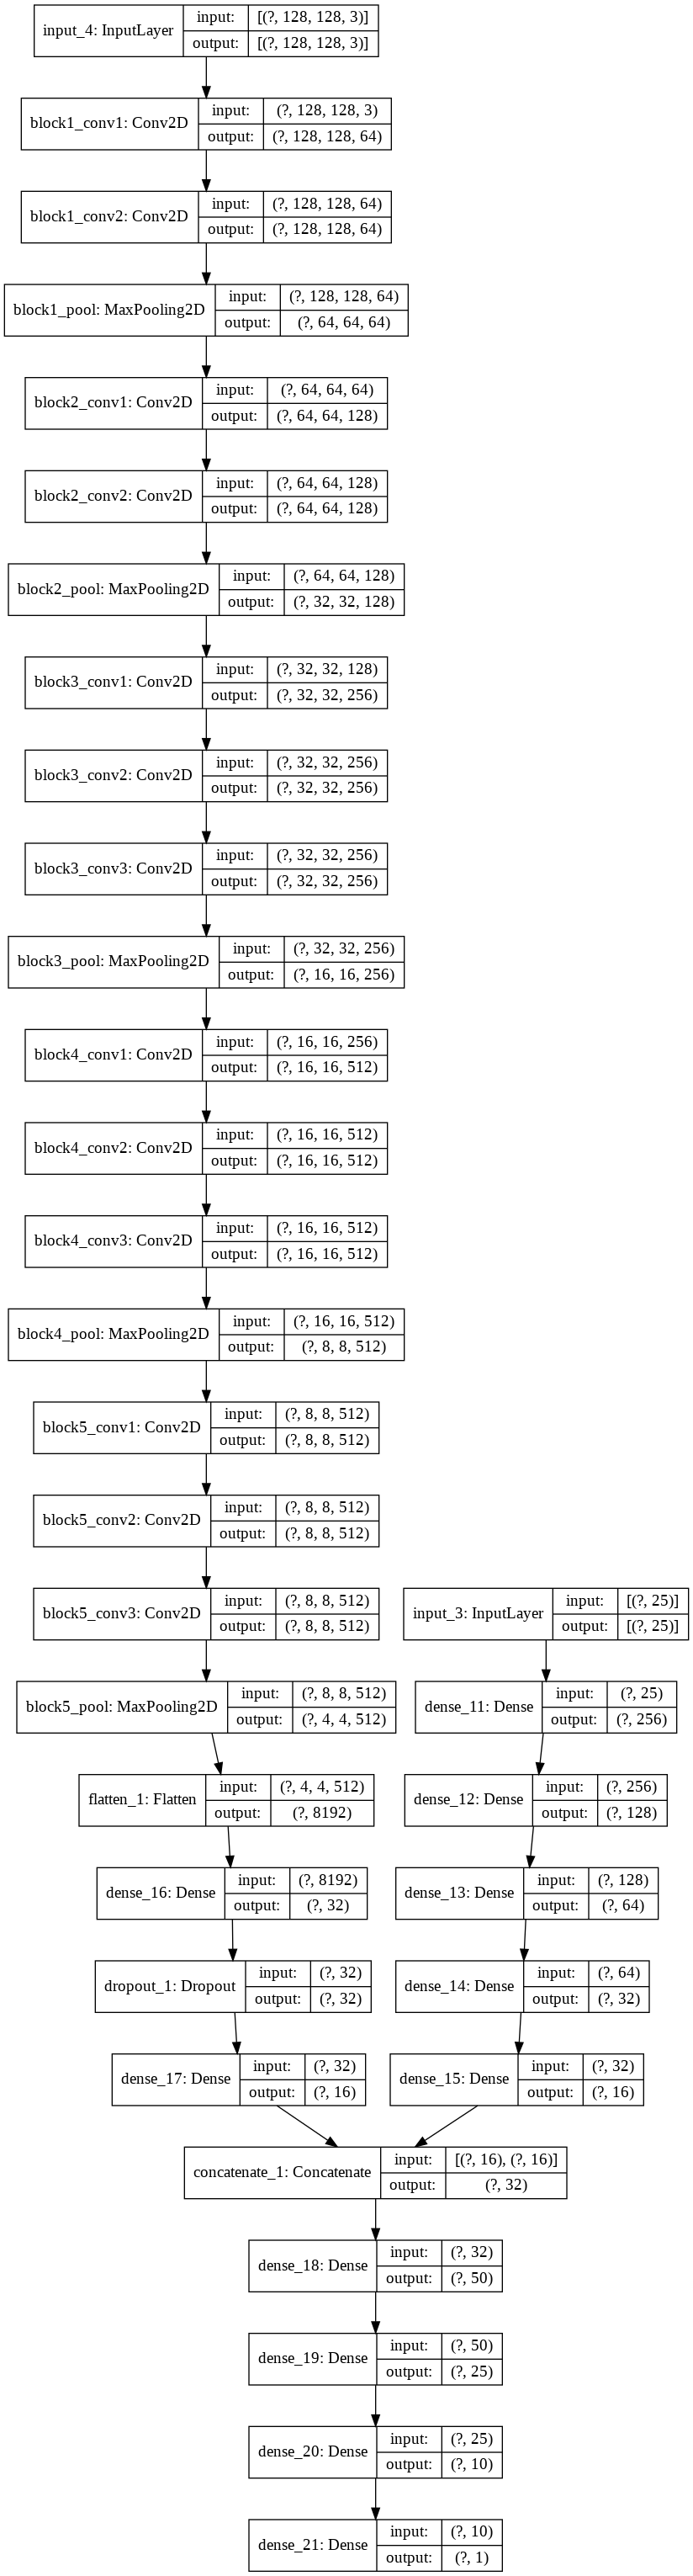

In [ ]:
checkpointer = ModelCheckpoint(filepath=dataset_path+"dnn/best_weights_project3.hdf5", 
                               verbose=0, save_best_only=True) # save best model

# input model for NN
visible_nn = Input(shape=(x_train.shape[1],))
x = Dense(256, activation='relu')(visible_nn)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
model_nn = Model(inputs=visible_nn, outputs=x)


# input model for CNN
vgg_model = VGG16(weights='imagenet', include_top=False, 
                  input_shape=(img_arr.shape[1], img_arr.shape[2], 
                               img_arr.shape[3]))   #  first hidden layer

model_cnn = Sequential()

for layer in vgg_model.layers:
    model_cnn.add(layer)

for model in model_cnn.layers:
    layer.trainable = False

model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(16, activation='relu'))


# merge input models
merge = concatenate([model_nn.output, model_cnn.output])

# adding more layers to the model
x = Dense(50, activation='relu')(merge)
x = Dense(25, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model(inputs=[model_nn.input, model_cnn.input], outputs=x)

print(model.summary())
plot_model(model, 
#            to_file='plots/multiple_inputs.png', 
           show_shapes=True)





# Train the test data set with the new model with VGG16 model with early stopping

In [ ]:
for i in range(15):
    # adam = optimizers.Adam(lr=1e-3, decay=1e-3/200)
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                            verbose=1, mode='auto')
    print('Train... TRY {}'.format(i))
    
    model.fit([x_train, img_train], y_train, 
              validation_data=([x_test, img_test], y_test),
              callbacks=[monitor, checkpointer], verbose=2, epochs=1000,
              batch_size=32)

Train... TRY 0
Epoch 1/1000
6/6 - 3s - loss: 912373317632.0000 - val_loss: 261158535168.0000
Epoch 2/1000
6/6 - 1s - loss: 255775539200.0000 - val_loss: 271728066560.0000
Epoch 3/1000
6/6 - 1s - loss: 257606156288.0000 - val_loss: 271672590336.0000
Epoch 4/1000
6/6 - 1s - loss: 256807206912.0000 - val_loss: 261040668672.0000
Epoch 5/1000
6/6 - 1s - loss: 171914772480.0000 - val_loss: 57217474560.0000
Epoch 6/1000
6/6 - 1s - loss: 117999796224.0000 - val_loss: 55062618112.0000
Epoch 7/1000
6/6 - 1s - loss: 102611648512.0000 - val_loss: 68469497856.0000
Epoch 8/1000
6/6 - 1s - loss: 95192129536.0000 - val_loss: 55882964992.0000
Epoch 9/1000
6/6 - 1s - loss: 91078057984.0000 - val_loss: 85996249088.0000
Epoch 10/1000
6/6 - 1s - loss: 92799115264.0000 - val_loss: 89334595584.0000
Epoch 11/1000
6/6 - 1s - loss: 78696284160.0000 - val_loss: 109519994880.0000
Epoch 00011: early stopping
Train... TRY 1
Epoch 1/1000
6/6 - 1s - loss: 1179411939328.0000 - val_loss: 263862484992.0000
Epoch 2/1000


#Predcit the test data set with the new transfer learning model and check the RMSE score

In [ ]:
# model.load_weights(dataset_path+'dnn/best_weights_project3.hdf5') # load weights from best model
pred = model.predict([x_test, img_test])

score = np.sqrt(metrics.mean_squared_error(y_test, pred)) 

print("Score (RMSE)\t: {}".format(score))
print("R2 score\t:", metrics.r2_score(y_test, pred))
print("MSE\t\t:", metrics.mean_squared_error(y_test, pred))


Score (RMSE)	: 110864.49681598523
R2 score	: 0.7220416752690406
MSE		: 12290936654.261599


#Plot the regression lift chart for the new model

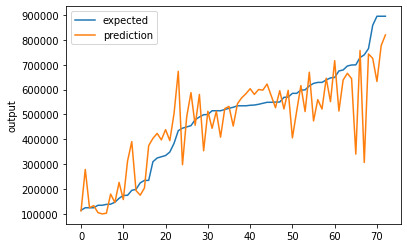

In [ ]:
ai_helper.chart_regression(pred.flatten(), y_test)